Carga de datos y procesamiento

C:\Users\rrive\AppData\Local\Temp\ipykernel_20772\2959397603.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CN'].replace(-999.0, np.nan, inplace=True)
C:\Users\rrive\AppData\Local\Temp\ipykernel_20772\2959397603.py:68: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

Skewness of numeric attributes:
CN    0.625782
CM    0.599900
dtype: float64


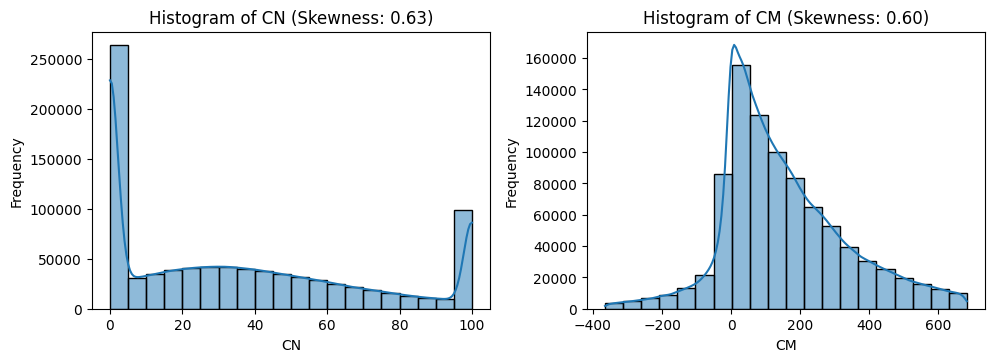

Skewness of numeric attributes:
CN    0.509409
CM    1.000827
dtype: float64


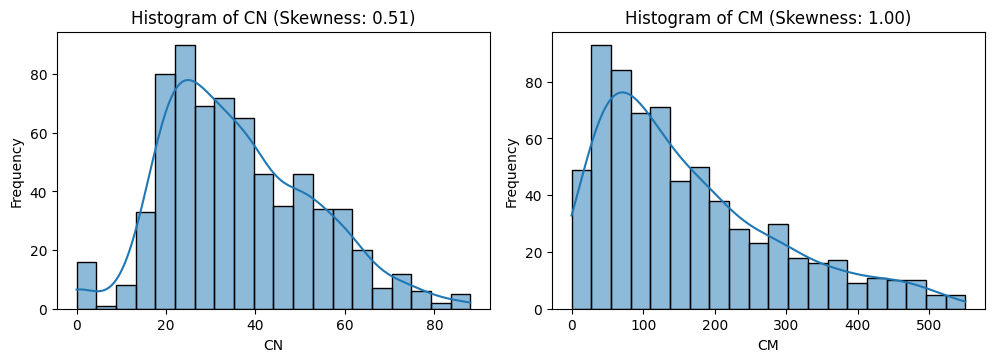

Skewness of numeric attributes:
CN    0.509409
CM    1.000827
dtype: float64


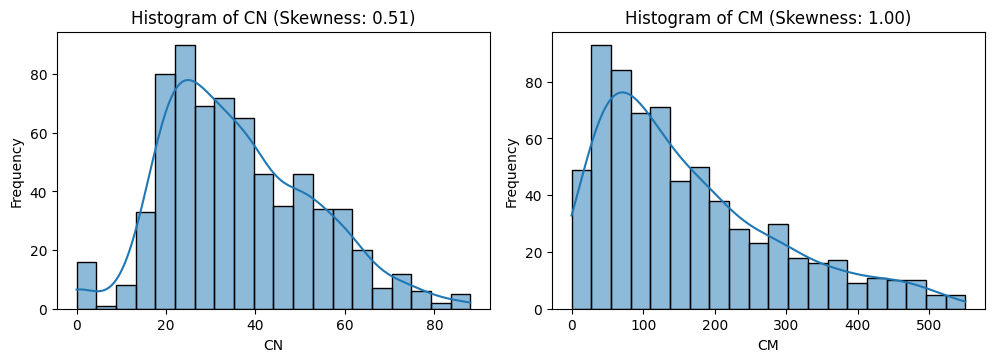

                               Meses      Dias   CN_norm   CM_norm  \
Meses                       1.000000  0.020585  0.438867  0.304037   
Dias                        0.020585  1.000000  0.091670  0.073498   
CN_norm                     0.438867  0.091670  1.000000  0.635185   
CM_norm                     0.304037  0.073498  0.635185  1.000000   
TEMPERATURA (°C)            0.026232  0.028031  0.095705  0.100323   
PRECIPITACIÓN (mm/hora)    -0.060824  0.023035 -0.274194 -0.297621   
HUMEDAD (%)                -0.163863 -0.044737 -0.514550 -0.353040   
VELOCIDAD DEL VIENTO (m/s)  0.163669  0.032065  0.435232  0.191674   
Estaciones                  0.559105  0.014524  0.535995  0.443183   
spline_0_Meses              0.698038  0.029783  0.398330  0.272342   
spline_1_Meses              0.317042  0.022826 -0.122432 -0.261045   
spline_2_Meses             -0.696431 -0.031702 -0.515888 -0.480328   
spline_3_Meses             -0.506818 -0.032854 -0.401340 -0.096157   
spline_4_Meses      

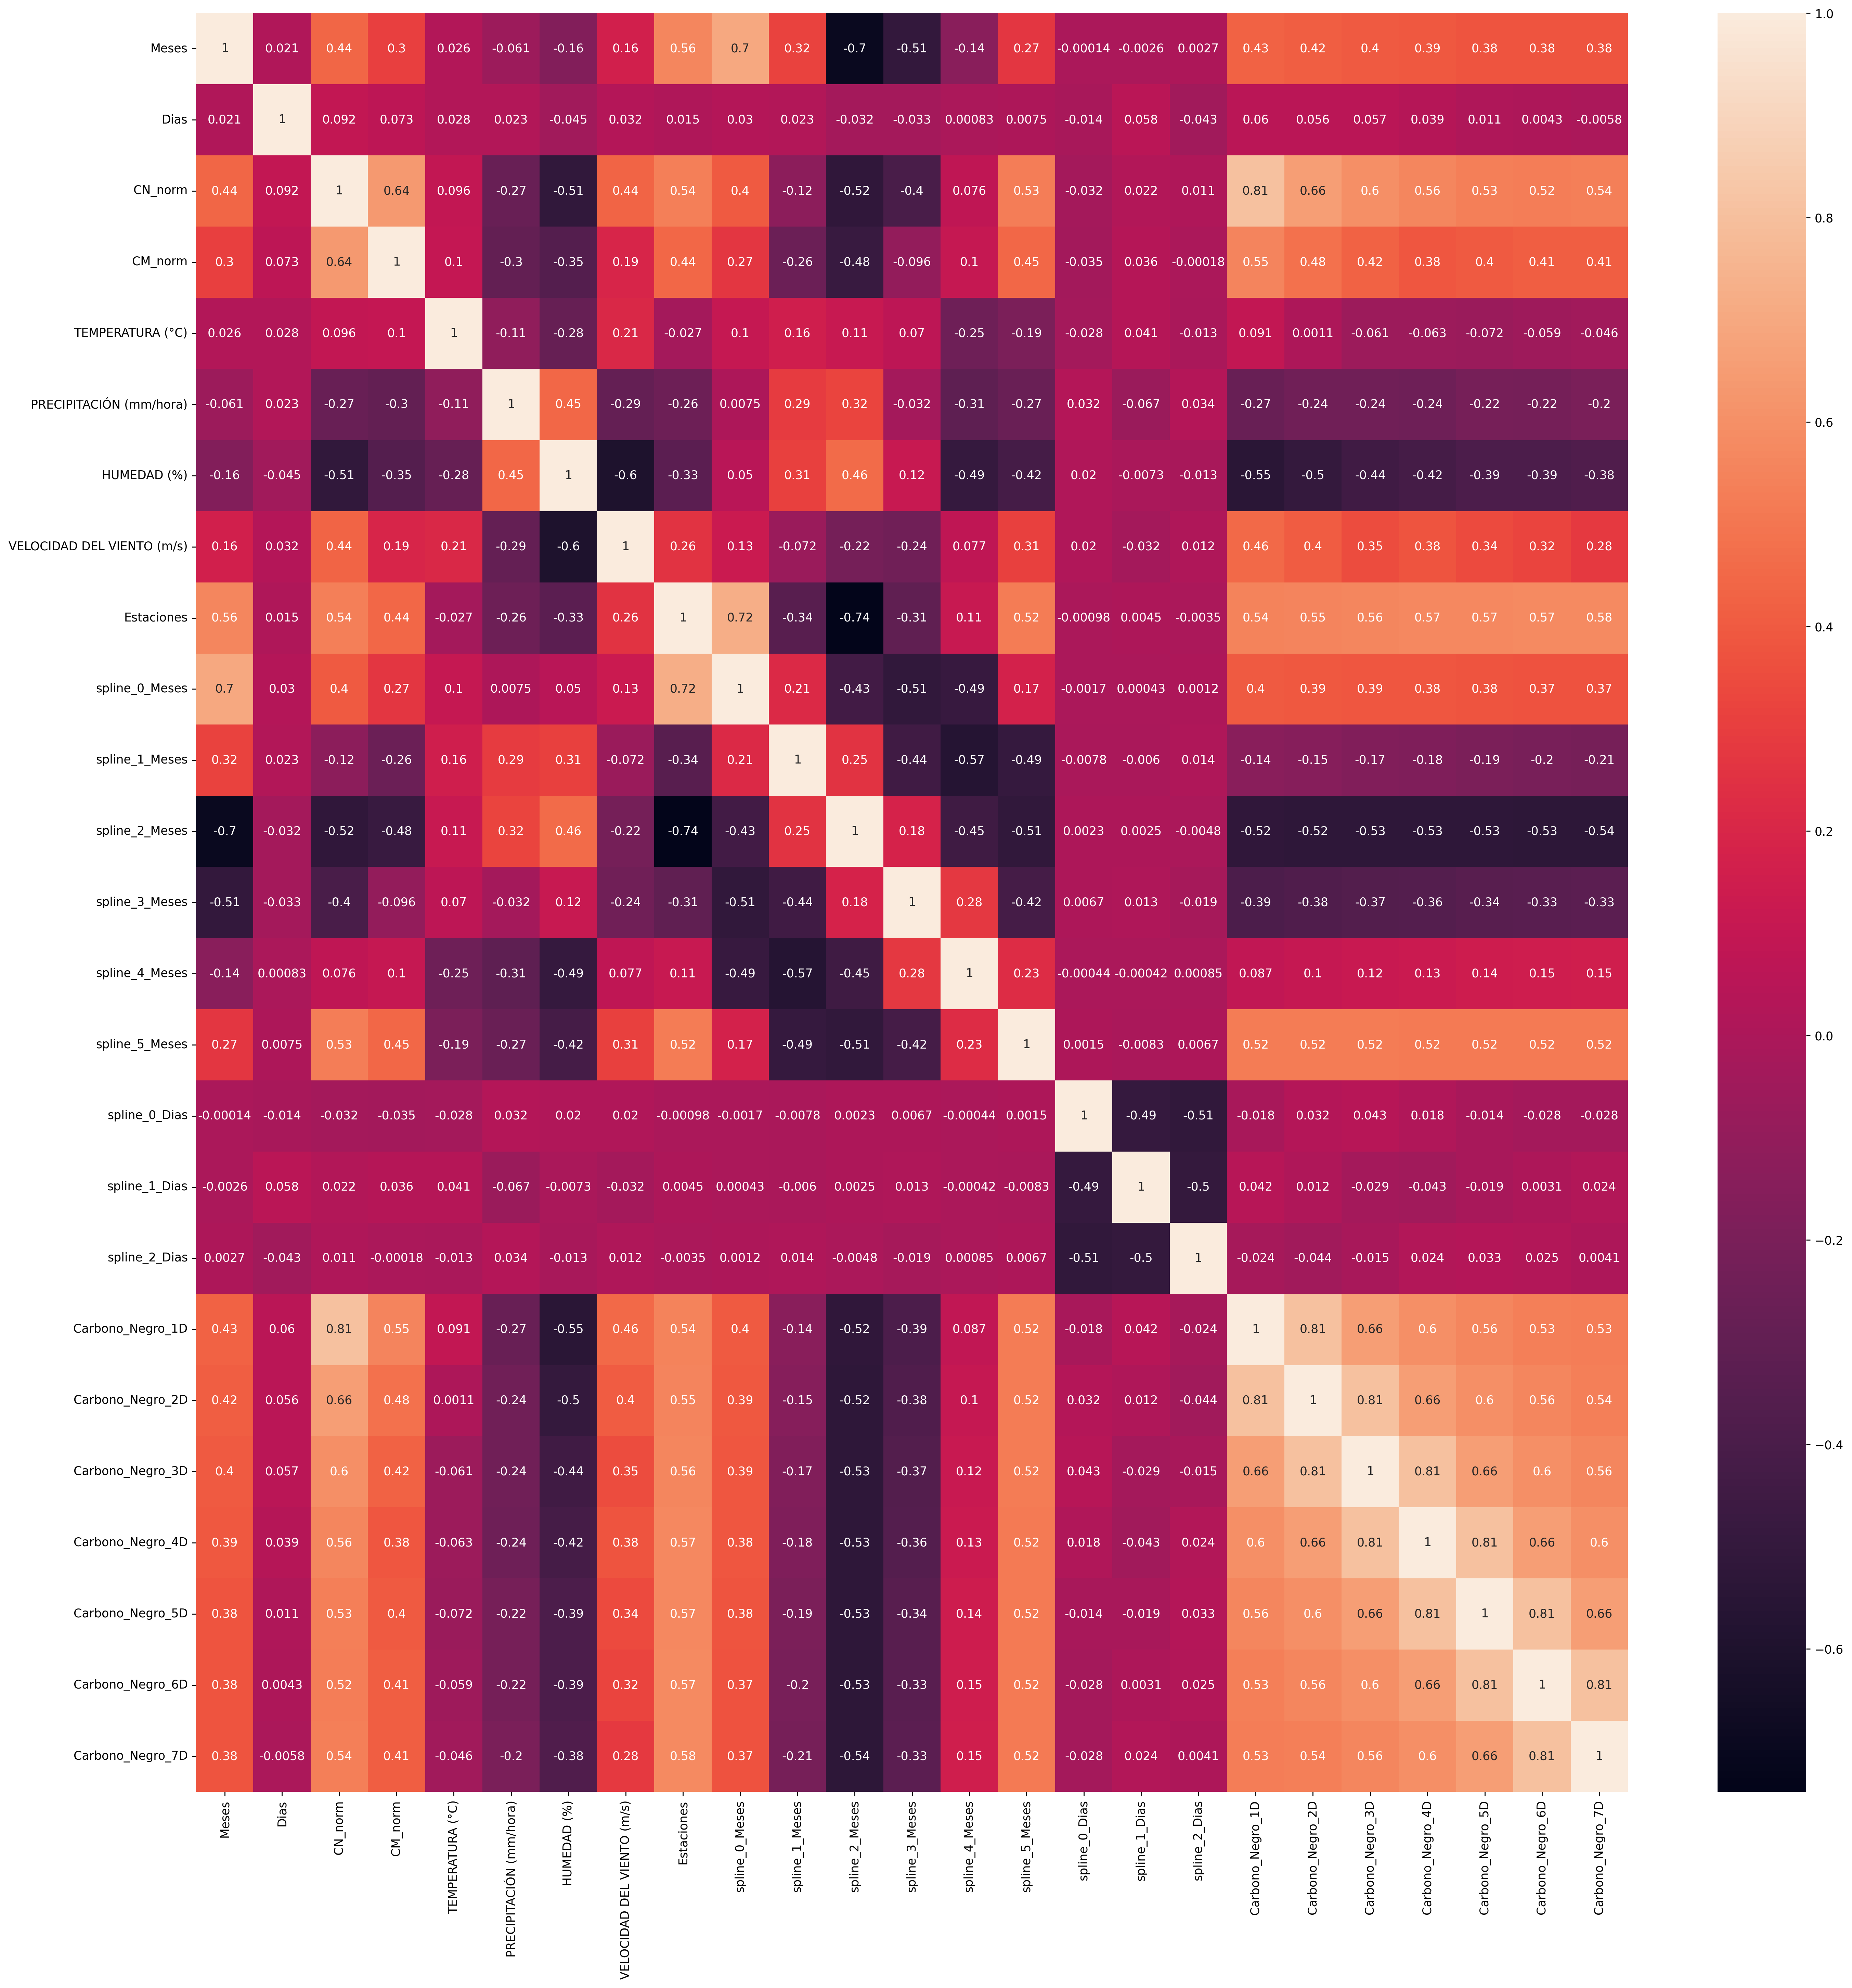

In [1]:
#Importacion de librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import MinMaxScaler, SplineTransformer
import seaborn as sns
from sklearn.model_selection import train_test_split 

#Fuente - Bsplines - Time feature engineering
#https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html
def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )


#Funcion de visualizacion de Skewnes de la data
def visualizar_datos_skew():
    skewness_values = df[numeric_attributes].skew()
    print("Skewness of numeric attributes:")
    print(skewness_values)
    plt.figure(figsize=(15, 10))
    for i, attribute in enumerate(numeric_attributes):
        plt.subplot(3, 3, i + 1)
        sns.histplot(df[attribute], kde=True, bins=20)
        plt.title(f'Histogram of {attribute} (Skewness: {skewness_values[attribute]:.2f})')
        plt.xlabel(attribute)
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

#Carga de datos - Black Carbon
df = pd.read_csv('Dataset.csv',sep=";")
#Configuracion de la variable "FECHA_CORTE" como Datetime
df['FECHA_CORTE'] = pd.to_datetime(df['FECHA_CORTE'].str.strip())
# Se eliminan las columnas de Spot_a, Spot_B, Factor, Flujo_Spot_A, Flujo_Spot_B
df = df.drop(['DEPARTAMENTO','PROVINCIA','DISTRITO','UBIGEO','EQUIPO','MARCA','MODELO','FECHA_CORTE.1','SPOT_A','SPOT_B','FACTOR','FLUJO_SPOT_A','FLUJO_SPOT_B'],axis=1)
#Año
df['Años'] = df['FECHA_CORTE'].dt.year
#Mes
df['Meses'] = df['FECHA_CORTE'].dt.month
#Dias
df['Dias'] = df['FECHA_CORTE'].dt.day
#Horas
df['Horas'] = df['FECHA_CORTE'].dt.hour

#Asignacion de la variable "FECHA_CORTE" como indice
df.set_index('FECHA_CORTE', inplace=True)

#Renombramiento de columnas
df['CN'] = df['BLACK_CARBON']
df['CM'] = df['BROWN_CARBON ']

#Filtracion de variables importantes
df = df[['CN', 'CM','Años','Meses','Dias']].copy()

#Eliminacion de outliers -999.0
df['CN'].replace(-999.0, np.nan, inplace=True)
df['CM'].replace(-999.0, np.nan, inplace=True)
df.dropna(subset=['CN', 'CM'], inplace=True)

#Filtrado de outliers mediante IQR
Q1 = df['CM'].quantile(0.25)
Q3 = df['CM'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['CM'] >= lower_bound) & (df['CM'] <= upper_bound)]

#Seleccion de variables numericas para visualizacion
numeric_attributes = ['CN','CM']

visualizar_datos_skew()

#Agrupacion por Dia = "D"
df = df.resample('D').mean()
df.dropna(how='all', inplace=True)

visualizar_datos_skew()

df.loc[df['CN'] < 0, 'CN'] = 0
df.loc[df['CM'] < 0, 'CM'] = 0

#Escalado de datos mediante Min Max
scaler = MinMaxScaler()
df[['CN_norm', 'CM_norm']] = scaler.fit_transform(df[['CN', 'CM']])

#Datos normalizados
visualizar_datos_skew()

#Introduccion de datos meteorologicos
Datos_meteorologicos = pd.read_csv('Datos_meteorologicos_procesados.csv')
Datos_meteorologicos['FECHA_CORTE'] = pd.to_datetime(Datos_meteorologicos['FECHA_CORTE'])
Datos_meteorologicos.set_index('FECHA_CORTE', inplace=True)
Datos_meteorologicos.drop(['DIRECCION DEL VIENTO (°)'],axis='columns',inplace=True)


df = pd.concat([df,Datos_meteorologicos],axis=1, ignore_index=False)
df = df.dropna()


#Calculo de Bsplines
months_df = pd.DataFrame(df['Meses'])
splines = periodic_spline_transformer(12, n_splines=6).fit_transform(months_df)
splines_months_df = pd.DataFrame(
    splines,
    columns=[f"spline_{i}_Meses" for i in range(splines.shape[1])],
)

dias_df = pd.DataFrame(df['Dias'])
splines = periodic_spline_transformer(7, n_splines=3).fit_transform(dias_df)
splines_dias_df = pd.DataFrame(
    splines,
    columns=[f"spline_{i}_Dias" for i in range(splines.shape[1])],
)

#Se Agregar la variable de las estaciones
df['Estaciones']=df.index.month%12//3+1
df = df.reset_index(drop=True)

#Se junta los splines con el dataset procesado
df = pd.concat([df, splines_months_df], axis="columns")
df = pd.concat([df, splines_dias_df], axis="columns")

#Creacion de variables objetivos
df['Carbono_Negro_1D'] = df['CN_norm'].shift(-1)
df['Carbono_Negro_2D'] = df['CN_norm'].shift(-2)
df['Carbono_Negro_3D'] = df['CN_norm'].shift(-3)
df['Carbono_Negro_4D'] = df['CN_norm'].shift(-4)
df['Carbono_Negro_5D'] = df['CN_norm'].shift(-5)
df['Carbono_Negro_6D'] = df['CN_norm'].shift(-6)
df['Carbono_Negro_7D'] = df['CN_norm'].shift(-7)
df = df.dropna()

#Filtrado final de variables
df_preparado = df.drop(['CN','CM','Años'],axis=1)

figure(figsize=(27, 27), dpi=250)
matriz_correlacion = df_preparado.corr()
print(matriz_correlacion)
sns.heatmap(matriz_correlacion, annot=True)
plt.show()


Prediccion mediante modelos sin optimizacion de hyperparametros

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import PredictionErrorDisplay
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
import lightgbm as lgb
import csv
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import PredictionErrorDisplay
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
plt.rcParams["font.size"] = 8
def visualizar_residuos():
    for i in range(len(Predictions)):
        fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
        PredictionErrorDisplay.from_predictions(
            y_test,
            y_pred=Predictions[i],
            kind="actual_vs_predicted",
            subsample=100,
            ax=axs[0],
            random_state=0,
        )
        axs[0].set_title("Actual vs. Predicted values")
        PredictionErrorDisplay.from_predictions(
            y_test,
            y_pred=Predictions[i],
            kind="residual_vs_predicted",
            subsample=100,
            ax=axs[1],
            random_state=0,
        )
        axs[1].set_title("Residuals vs. Predicted Values")
        fig.suptitle("Plotting cross-validated predictions")
        plt.tight_layout()
        plt.show()
        


#Variable objetivo
targets = ['Carbono_Negro_1D','Carbono_Negro_2D','Carbono_Negro_3D','Carbono_Negro_4D','Carbono_Negro_5D','Carbono_Negro_6D','Carbono_Negro_7D']

#Descriptores
X = df_preparado.drop(['Carbono_Negro_1D','Carbono_Negro_2D','Carbono_Negro_3D','Carbono_Negro_4D','Carbono_Negro_5D','Carbono_Negro_6D','Carbono_Negro_7D'],axis=1)

#Metricas
fieldnames= ['MSE','RMSE','R-squared','Correlation','MAE']

#Variables de almacenamiento
Por_modelo = []
with open('Resultados.csv', 'w', encoding='UTF8', newline='') as f:
    
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for target in targets:
            
            y = df_preparado[target]


            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

            models = {
                'Linear Regression': LinearRegression(),
                'Decision Tree': DecisionTreeRegressor(random_state=42),
                'Random Forest': RandomForestRegressor(random_state=42,n_estimators=100, criterion='squared_error', min_samples_split=2, min_samples_leaf=1),
                'XGBoost': XGBRegressor(random_state=42),
                'LightGBM': lgb.LGBMRegressor(verbose=-1),
                'Neural Network': MLPRegressor(random_state=42),
                'SVM - Linear': SVR(kernel = 'linear'),
                'SVM - RBF': SVR(kernel = 'rbf'),
                'SVM - Poly': SVR(kernel='poly', C=1.0, degree=3, gamma='scale'),
            }

            results = {}
            print("Resultado modelos - variable objetivo {}".format(target))
            print("{:<15s} {:>12s} {:>10s} {:>13} {:>13} {:>4}".format("Nombre","MSE","RMSE","R-squared","Correlation","MAE"))
            Predictions = []

            for name, model in models.items():
                try:
                    #Entrenamiento del modelo
                    model.fit(X_train, y_train)
                    #Predicciones
                    y_pred = model.predict(X_test)
                    #Se guardan los resultados
                    Predictions.append(y_pred)
                    
                    #Estadistica
                    mse = mean_squared_error(y_test, y_pred)
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                    mae = mean_absolute_error(y_test, y_pred)
                    r2 = r2_score(y_test, y_pred)

                    # Calculate the correlation coefficient between the actual and predicted values
                    dt_correlation = np.corrcoef(y_test, y_pred)[0, 1]
                    
                    results[name] = {'MSE': mse,'RMSE':rmse, 'R-squared': r2, 'Correlation': dt_correlation,'MAE':mae}
                    row = {'MSE': mse,'RMSE':rmse, 'R-squared': r2, 'Correlation': dt_correlation,'MAE':mae}
                    writer.writerow(row)
                    print('{:<24} {:<9.4f} {:<8.4f} {:<11.4f} {:<12.4f} {:<13.4f}'.format(name,mse,rmse,r2,dt_correlation,mae))
                    # print(f'{name:<10}  {mse:<13.4f}{rmse:>7.4f}{r2:>7.4f}{dt_correlation:>10.4f}{mae:>12.4f}')

                except ValueError as e:
                    print(f"Error training {name}: {e}")
                    results[name] = {'MSE': float('NaN'),'RMSE': float('NaN'), 'R-squared': float('NaN') , 'Correlation': float('NaN'),'MAE': float('NaN')}
                    continue
            Por_modelo.append(Predictions)       
            print("Numero de instancias: {}".format(len(y_test)))
            print('\n')

            # #Visualziacion de residuos
            # fig, axs = plt.subplots(ncols=2,nrows=9, figsize=(7, 26))
            # names = list(models.keys())
            # for i in range(len(Predictions)):
            #     PredictionErrorDisplay.from_predictions(
            #         y_test,
            #         y_pred=Predictions[i],
            #         kind="actual_vs_predicted",
            #         subsample=100,
            #         ax=axs[i,0],
            #         random_state=0,
            #     )
            #     axs[i,0].set_title("Actual vs. Predicted values - {}".format(names[i]))
            #     PredictionErrorDisplay.from_predictions(
            #         y_test,
            #         y_pred=Predictions[i],
            #         kind="residual_vs_predicted",
            #         subsample=100,
            #         ax=axs[i,1],
            #         random_state=0,
            #     )
            #     axs[i,1].set_title("Residuos vs. Valores predecidos - {}".format(names[i]))

            # # fig.suptitle("Grafico de predicciones")
            # plt.tight_layout()
            # plt.show()
            # #visualizar_residuos()
            # print("Numero de instancias: {}".format(len(y_test)))
            # print('\n')

Resultado modelos - variable objetivo Carbono_Negro_1D
Nombre                   MSE       RMSE     R-squared   Correlation  MAE
Linear Regression        0.0105    0.1024   0.7014      0.8413       0.0795       
Decision Tree            0.0203    0.1425   0.4217      0.7120       0.1062       
Random Forest            0.0118    0.1085   0.6643      0.8169       0.0808       
XGBoost                  0.0132    0.1151   0.6225      0.7950       0.0872       
LightGBM                 0.0120    0.1097   0.6570      0.8158       0.0857       
Neural Network           0.0152    0.1232   0.5678      0.7627       0.0925       
SVM - Linear             0.0107    0.1035   0.6945      0.8408       0.0823       
SVM - RBF                0.0168    0.1297   0.5209      0.7362       0.1000       
SVM - Poly               0.0149    0.1220   0.5759      0.7720       0.0960       
Numero de instancias: 168


Resultado modelos - variable objetivo Carbono_Negro_2D
Nombre                   MSE       RMSE   

Hyperparametros - Decision Tree

In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

#Variable objetivo
targets = ['Carbono_Negro_1D','Carbono_Negro_2D','Carbono_Negro_3D','Carbono_Negro_4D','Carbono_Negro_5D','Carbono_Negro_6D','Carbono_Negro_7D']
X = df_preparado.drop(['Carbono_Negro_1D','Carbono_Negro_2D','Carbono_Negro_3D','Carbono_Negro_4D','Carbono_Negro_5D','Carbono_Negro_6D','Carbono_Negro_7D'],axis=1)
with open('Decisiton_tree.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for target in targets:
            y = df_preparado[target]

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
            models = {
                'Decision Tree': DecisionTreeRegressor(random_state=42),
            }

            for name, model in models.items():
                try:

                    param_grid = {
                    'criterion' : ['squared_error','friedman_mse','absolute_error','poisson'], # The number of samples to draw from the training set to train each tree.
                    'splitter': ['best'],
                    'min_samples_split': [None, 2,3, 4,5,6,7,8,9,10], # The number of trees in the forest
                    'max_depth': [None,1,2,3,4, 5,6,7,8,9, 10], # The maximum depth of the tree. If None, then nodes are expanded until
                    'max_features':[None, 'sqrt', 'log2']
                    }


                    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2') # cv: cross-validation
                    grid_search.fit(X_train, y_train)

                    # Print the best hyperparameters
                    print("Best hyperparameters:", grid_search.best_params_)

                    # Train the model with the best hyperparameters
                    best_model = grid_search.best_estimator_
                    best_model.fit(X_train, y_train)
                    model = best_model

                    #Entrenamiento del modelo
                    model.fit(X_train, y_train)
                    #Predicciones
                    y_pred = model.predict(X_test)
                    #Se guardan los resultados
                    Predictions.append(y_pred)
                    
                    #Estadistica
                    mse = mean_squared_error(y_test, y_pred)
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                    mae = mean_absolute_error(y_test, y_pred)
                    r2 = r2_score(y_test, y_pred)

                    # Calculate the correlation coefficient between the actual and predicted values
                    dt_correlation = np.corrcoef(y_test, y_pred)[0, 1]

                    results[name] = {'MSE': mse,'RMSE':rmse, 'R-squared': r2, 'Correlation': dt_correlation,'MAE':mae}
                    row = {'MSE': mse,'RMSE':rmse, 'R-squared': r2, 'Correlation': dt_correlation,'MAE':mae}
                    print('{:<24} {:<9.4f} {:<8.4f} {:<11.4f} {:<12.4f} {:<13.4f}'.format(name,mse,rmse,r2,dt_correlation,mae))
                    writer.writerow(row)
                    writer.writerow(grid_search.best_params_)
                    print('{:<24} {:<9.4f} {:<8.4f} {:<11.4f} {:<12.4f} {:<13.4f}'.format(name,mse,rmse,r2,dt_correlation,mae))
                    # print(f'{name:<10}  {mse:<13.4f}{rmse:>7.4f}{r2:>7.4f}{dt_correlation:>10.4f}{mae:>12.4f}')

                except ValueError as e:
                    pass
                    results[name] = {'MSE': float('NaN'),'RMSE': float('NaN'), 'R-squared': float('NaN') , 'Correlation': float('NaN'),'MAE': float('NaN')}
                    continue



Best hyperparameters: {'criterion': 'poisson', 'max_depth': 3, 'max_features': None, 'min_samples_split': 2, 'splitter': 'best'}
Decision Tree            0.0125    0.1117   0.6447      0.8037       0.0822       
Best hyperparameters: {'criterion': 'poisson', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 7, 'splitter': 'best'}
Decision Tree            0.0216    0.1471   0.3268      0.6145       0.1108       
Best hyperparameters: {'criterion': 'squared_error', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 4, 'splitter': 'best'}
Decision Tree            0.0229    0.1514   0.3255      0.6023       0.1153       
Best hyperparameters: {'criterion': 'absolute_error', 'max_depth': 3, 'max_features': None, 'min_samples_split': 2, 'splitter': 'best'}
Decision Tree            0.0200    0.1413   0.4387      0.6675       0.1037       
Best hyperparameters: {'criterion': 'squared_error', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_split': 8, 'splitter': 'best'

Hyperparametros - Neural Network

In [63]:
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

#Variable objetivo
targets = ['Carbono_Negro_1D','Carbono_Negro_2D','Carbono_Negro_3D','Carbono_Negro_4D','Carbono_Negro_5D','Carbono_Negro_6D','Carbono_Negro_7D']
X = df_preparado.drop(['Carbono_Negro_1D','Carbono_Negro_2D','Carbono_Negro_3D','Carbono_Negro_4D','Carbono_Negro_5D','Carbono_Negro_6D','Carbono_Negro_7D'],axis=1)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for target in targets:
        y = df_preparado[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
        models = {
            'Neural Network': MLPRegressor(early_stopping=True,random_state=42),
        }

        for name, model in models.items():
            try:

                param_grid = {
                    'loss':['squared_error','poisson'],
                    'activation':['logistic','tanh','relu'],
                    'hidden_layer_sizes':[(100,),(100,20)],
                    'max_iter':[200,500],
                    'solver':['lbfgs','sgd','adam'],
                    #'alpha':[0.0002,0.0001,0.001,0.01,0.1],
                    'learning_rate':['constant','invscaling','adaptive'],
                    #'learning_rate_init':[0.001,0.002,0.003,0.01,0.1],
                }


                grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2') # cv: cross-validation
                grid_search.fit(X_train, y_train)

                # Print the best hyperparameters
                print("Best hyperparameters:", grid_search.best_params_)

                # Train the model with the best hyperparameters
                best_model = grid_search.best_estimator_
                best_model.fit(X_train, y_train)
                model = best_model


                #Entrenamiento del modelo
                model.fit(X_train, y_train)
                #Predicciones
                y_pred = model.predict(X_test)
                #Se guardan los resultados
                Predictions.append(y_pred)
                
                #Estadistica
                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)

                # Calculate the correlation coefficient between the actual and predicted values
                dt_correlation = np.corrcoef(y_test, y_pred)[0, 1]

                results[name] = {'MSE': mse,'RMSE':rmse, 'R-squared': r2, 'Correlation': dt_correlation,'MAE':mae}
                print('{:<24} {:<9.4f} {:<8.4f} {:<11.4f} {:<12.4f} {:<13.4f}'.format(name,mse,rmse,r2,dt_correlation,mae))
                # print(f'{name:<10}  {mse:<13.4f}{rmse:>7.4f}{r2:>7.4f}{dt_correlation:>10.4f}{mae:>12.4f}')

            except ValueError as e:
                print(f"Error training {name}: {e}")
                results[name] = {'MSE': float('NaN'),'RMSE': float('NaN'), 'R-squared': float('NaN') , 'Correlation': float('NaN'),'MAE': float('NaN')}
                continue



Best hyperparameters: {'activation': 'logistic', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'loss': 'squared_error', 'max_iter': 200, 'solver': 'lbfgs'}
Neural Network           0.0112    0.1059   0.6804      0.8290       0.0817       
Best hyperparameters: {'activation': 'logistic', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'loss': 'squared_error', 'max_iter': 200, 'solver': 'lbfgs'}
Neural Network           0.0152    0.1231   0.5284      0.7340       0.0971       
Best hyperparameters: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'loss': 'squared_error', 'max_iter': 200, 'solver': 'lbfgs'}
Neural Network           0.0253    0.1591   0.2554      0.5749       0.1180       
Best hyperparameters: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'loss': 'squared_error', 'max_iter': 200, 'solver': 'lbfgs'}
Neural Network           0.0211    0.1452   0.4075      0.6505       0.1094       


Hyperparametros - Random Forest

In [64]:
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

#Variable objetivo
targets = ['Carbono_Negro_1D','Carbono_Negro_2D','Carbono_Negro_3D','Carbono_Negro_4D','Carbono_Negro_5D','Carbono_Negro_6D','Carbono_Negro_7D']
X = df_preparado.drop(['Carbono_Negro_1D','Carbono_Negro_2D','Carbono_Negro_3D','Carbono_Negro_4D','Carbono_Negro_5D','Carbono_Negro_6D','Carbono_Negro_7D'],axis=1)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for target in targets:
        y = df_preparado[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
        
        models = {
            'Random Forest': RandomForestRegressor(n_jobs=4,random_state=42),
        }

        for name, model in models.items():
            try:

                param_grid = {
                'criterion':['squared_error','absolute_error','logpoisson_loss','friedman_mse'],
                #'max_samples' : [None, 10,20,30], # The number of samples to draw from the training set to train each tree.
                'n_estimators': [100, 200, 300], # The number of trees in the forest
                #'max_depth': [None, 3,6,9], # The maximum depth of the tree. If None, then nodes are expanded until
                'min_samples_split': [2,5,10],  #The minimum number of samples required to split an internal node
                'min_samples_leaf':[1,2,4],
                }


                grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2') # cv: cross-validation
                grid_search.fit(X_train, y_train)

                # Print the best hyperparameters
                print("Best hyperparameters:", grid_search.best_params_)

                # Train the model with the best hyperparameters
                best_model = grid_search.best_estimator_
                best_model.fit(X_train, y_train)
                model = best_model

                #Entrenamiento del modelo
                model.fit(X_train, y_train)
                #Predicciones
                y_pred = model.predict(X_test)
                #Se guardan los resultados
                Predictions.append(y_pred)
                
                #Estadistica
                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)

                # Calculate the correlation coefficient between the actual and predicted values
                dt_correlation = np.corrcoef(y_test, y_pred)[0, 1]

                results[name] = {'MSE': mse,'RMSE':rmse, 'R-squared': r2, 'Correlation': dt_correlation,'MAE':mae}
                print('{:<24} {:<9.4f} {:<8.4f} {:<11.4f} {:<12.4f} {:<13.4f}'.format(name,mse,rmse,r2,dt_correlation,mae))
                # print(f'{name:<10}  {mse:<13.4f}{rmse:>7.4f}{r2:>7.4f}{dt_correlation:>10.4f}{mae:>12.4f}')

            except ValueError as e:
                pass
                results[name] = {'MSE': float('NaN'),'RMSE': float('NaN'), 'R-squared': float('NaN') , 'Correlation': float('NaN'),'MAE': float('NaN')}
                continue



Best hyperparameters: {'criterion': 'absolute_error', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Random Forest            0.0114    0.1069   0.6746      0.8233       0.0793       
Best hyperparameters: {'criterion': 'squared_error', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Random Forest            0.0158    0.1257   0.5082      0.7175       0.0982       
Best hyperparameters: {'criterion': 'squared_error', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest            0.0218    0.1476   0.3595      0.6134       0.1077       
Best hyperparameters: {'criterion': 'absolute_error', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest            0.0181    0.1346   0.4905      0.7013       0.1016       
Best hyperparameters: {'criterion': 'absolute_error', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest            0.0177    0.1332   0.5382      0.7

Hyperparametros - XGBoost

In [65]:
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

#Variable objetivo
targets = ['Carbono_Negro_1D','Carbono_Negro_2D','Carbono_Negro_3D','Carbono_Negro_4D','Carbono_Negro_5D','Carbono_Negro_6D','Carbono_Negro_7D']
X = df_preparado.drop(['Carbono_Negro_1D','Carbono_Negro_2D','Carbono_Negro_3D','Carbono_Negro_4D','Carbono_Negro_5D','Carbono_Negro_6D','Carbono_Negro_7D'],axis=1)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for target in targets:
        y = df_preparado[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
        models = {
            'XGBoost': XGBRegressor(n_jobs=4, random_state=42)
        }

        for name, model in models.items():
            try:

                param_grid = {
                'n_estimators': [100,200,300,400],
                'max_depth': [3,4,5,6],
                'learning_rate': [0.3,0.1,0.05],
                'min_child_weight': [1,2,3,4],
                'gamma': [0,0.1,0.3,0.5]
                }


                grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2') # cv: cross-validation
                grid_search.fit(X_train, y_train)

                # Print the best hyperparameters
                print("Best hyperparameters:", grid_search.best_params_)

                # Train the model with the best hyperparameters
                best_model = grid_search.best_estimator_
                best_model.fit(X_train, y_train)
                model = best_model

                #Entrenamiento del modelo
                model.fit(X_train, y_train)
                #Predicciones
                y_pred = model.predict(X_test)
                #Se guardan los resultados
                Predictions.append(y_pred)
                
                #Estadistica
                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)

                # Calculate the correlation coefficient between the actual and predicted values
                dt_correlation = np.corrcoef(y_test, y_pred)[0, 1]

                results[name] = {'MSE': mse,'RMSE':rmse, 'R-squared': r2, 'Correlation': dt_correlation,'MAE':mae}
                print('{:<24} {:<9.4f} {:<8.4f} {:<11.4f} {:<12.4f} {:<13.4f}'.format(name,mse,rmse,r2,dt_correlation,mae))
                # print(f'{name:<10}  {mse:<13.4f}{rmse:>7.4f}{r2:>7.4f}{dt_correlation:>10.4f}{mae:>12.4f}')

            except ValueError as e:
                pass
                results[name] = {'MSE': float('NaN'),'RMSE': float('NaN'), 'R-squared': float('NaN') , 'Correlation': float('NaN'),'MAE': float('NaN')}
                continue



Best hyperparameters: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 100}
XGBoost                  0.0108    0.1040   0.6918      0.8334       0.0781       
Best hyperparameters: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100}
XGBoost                  0.0165    0.1284   0.4872      0.7057       0.0994       
Best hyperparameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100}
XGBoost                  0.0250    0.1581   0.2650      0.5680       0.1148       
Best hyperparameters: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 200}
XGBoost                  0.0180    0.1342   0.4941      0.7049       0.1013       
Best hyperparameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100}
XGBoost                  0.0184    0.1356   0.5215      0.7286       0.1031     

Hyperparametros - SVM

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

#Variable objetivo
targets = ['Carbono_Negro_1D','Carbono_Negro_2D','Carbono_Negro_3D','Carbono_Negro_4D','Carbono_Negro_5D','Carbono_Negro_6D','Carbono_Negro_7D']
X = df_preparado.drop(['Carbono_Negro_1D','Carbono_Negro_2D','Carbono_Negro_3D','Carbono_Negro_4D','Carbono_Negro_5D','Carbono_Negro_6D','Carbono_Negro_7D'],axis=1)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for target in targets:
        y = df_preparado[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
        models = {
            #'Linear Regression': LinearRegression(),
            #'Decision Tree': DecisionTreeRegressor(random_state=42),
            #'Neural Network': MLPRegressor(hidden_layer_sizes=(100,20,), max_iter=500, random_state=42),
            #'Random Forest': RandomForestRegressor(random_state=42),
            #'XGBoost': XGBRegressor(n_estimators=200, random_state=42),
            'SVM' : SVR(kernel='linear'),
        }

        for name, model in models.items():
            try:

                param_grid = {
                #'kernel':['linear','poly','rbf','sigmoid'],
                #'degree' : [3],
                'C': [0.1, 1, 10, 100],
                'epsilon': [0.01, 0.1, 0.5, 1],
                'gamma': ['scale', 'auto', 0.01, 0.1, 1]
                }


                grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2') # cv: cross-validation
                grid_search.fit(X_train, y_train)

                # Print the best hyperparameters
                print("Best hyperparameters:", grid_search.best_params_)

                # Train the model with the best hyperparameters
                best_model = grid_search.best_estimator_
                best_model.fit(X_train, y_train)
                model = best_model

                #Entrenamiento del modelo
                model.fit(X_train, y_train)
                #Predicciones
                y_pred = model.predict(X_test)
                #Se guardan los resultados
                Predictions.append(y_pred)
                
                #Estadistica
                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)

                # Calculate the correlation coefficient between the actual and predicted values
                dt_correlation = np.corrcoef(y_test, y_pred)[0, 1]

                results[name] = {'MSE': mse,'RMSE':rmse, 'R-squared': r2, 'Correlation': dt_correlation,'MAE':mae}
                print('{:<24} {:<9.4f} {:<8.4f} {:<11.4f} {:<12.4f} {:<13.4f}'.format(name,mse,rmse,r2,dt_correlation,mae))
                # print(f'{name:<10}  {mse:<13.4f}{rmse:>7.4f}{r2:>7.4f}{dt_correlation:>10.4f}{mae:>12.4f}')

            except ValueError as e:
                print(f"Error training {name}: {e}")
                results[name] = {'MSE': float('NaN'),'RMSE': float('NaN'), 'R-squared': float('NaN') , 'Correlation': float('NaN'),'MAE': float('NaN')}
                continue



In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

#Variable objetivo
targets = ['Carbono_Negro_1D','Carbono_Negro_2D','Carbono_Negro_3D','Carbono_Negro_4D','Carbono_Negro_5D','Carbono_Negro_6D','Carbono_Negro_7D']
X = df_preparado.drop(['Carbono_Negro_1D','Carbono_Negro_2D','Carbono_Negro_3D','Carbono_Negro_4D','Carbono_Negro_5D','Carbono_Negro_6D','Carbono_Negro_7D'],axis=1)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for target in targets:
        y = df_preparado[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
        models = {
            #'Linear Regression': LinearRegression(),
            #'Decision Tree': DecisionTreeRegressor(random_state=42),
            #'Neural Network': MLPRegressor(hidden_layer_sizes=(100,20,), max_iter=500, random_state=42),
            #'Random Forest': RandomForestRegressor(random_state=42),
            #'XGBoost': XGBRegressor(n_estimators=200, random_state=42),
            'SVM' : SVR(kernel='poly'),
        }

        for name, model in models.items():
            try:

                param_grid = {
                #'kernel':['linear','poly','rbf','sigmoid'],
                'degree' : [3,4,5,6,7,8,9,10],
                'C': [0.1, 1, 10, 100],
                'epsilon': [0.01, 0.1, 0.5, 1],
                'gamma': ['scale']
                }


                grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2') # cv: cross-validation
                grid_search.fit(X_train, y_train)

                # Print the best hyperparameters
                print("Best hyperparameters:", grid_search.best_params_)

                # Train the model with the best hyperparameters
                best_model = grid_search.best_estimator_
                best_model.fit(X_train, y_train)
                model = best_model

                #Entrenamiento del modelo
                model.fit(X_train, y_train)
                #Predicciones
                y_pred = model.predict(X_test)
                #Se guardan los resultados
                Predictions.append(y_pred)
                
                #Estadistica
                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)

                # Calculate the correlation coefficient between the actual and predicted values
                dt_correlation = np.corrcoef(y_test, y_pred)[0, 1]

                results[name] = {'MSE': mse,'RMSE':rmse, 'R-squared': r2, 'Correlation': dt_correlation,'MAE':mae}
                print('{:<24} {:<9.4f} {:<8.4f} {:<11.4f} {:<12.4f} {:<13.4f}'.format(name,mse,rmse,r2,dt_correlation,mae))
                # print(f'{name:<10}  {mse:<13.4f}{rmse:>7.4f}{r2:>7.4f}{dt_correlation:>10.4f}{mae:>12.4f}')

            except ValueError as e:
                print(f"Error training {name}: {e}")
                results[name] = {'MSE': float('NaN'),'RMSE': float('NaN'), 'R-squared': float('NaN') , 'Correlation': float('NaN'),'MAE': float('NaN')}
                continue



In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

#Variable objetivo
targets = ['Carbono_Negro_1D','Carbono_Negro_2D','Carbono_Negro_3D','Carbono_Negro_4D','Carbono_Negro_5D','Carbono_Negro_6D','Carbono_Negro_7D']
X = df_preparado.drop(['Carbono_Negro_1D','Carbono_Negro_2D','Carbono_Negro_3D','Carbono_Negro_4D','Carbono_Negro_5D','Carbono_Negro_6D','Carbono_Negro_7D'],axis=1)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for target in targets:
        y = df_preparado[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
        models = {
            #'Linear Regression': LinearRegression(),
            #'Decision Tree': DecisionTreeRegressor(random_state=42),
            #'Neural Network': MLPRegressor(hidden_layer_sizes=(100,20,), max_iter=500, random_state=42),
            #'Random Forest': RandomForestRegressor(random_state=42),
            #'XGBoost': XGBRegressor(n_estimators=200, random_state=42),
            'SVM' : SVR(kernel='rbf'),
        }

        for name, model in models.items():
            try:

                param_grid = {
                #'kernel':['linear','poly','rbf','sigmoid'],
                #'degree' : [3],
                'C': [0.1, 1, 10, 100],
                'epsilon': [0.01, 0.1, 0.5, 1],
                'gamma': ['scale', 'auto', 0.01, 0.1, 1]
                }


                grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2') # cv: cross-validation
                grid_search.fit(X_train, y_train)

                # Print the best hyperparameters
                print("Best hyperparameters:", grid_search.best_params_)

                # Train the model with the best hyperparameters
                best_model = grid_search.best_estimator_
                best_model.fit(X_train, y_train)
                model = best_model

                #Entrenamiento del modelo
                model.fit(X_train, y_train)
                #Predicciones
                y_pred = model.predict(X_test)
                #Se guardan los resultados
                Predictions.append(y_pred)
                
                #Estadistica
                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)

                # Calculate the correlation coefficient between the actual and predicted values
                dt_correlation = np.corrcoef(y_test, y_pred)[0, 1]

                results[name] = {'MSE': mse,'RMSE':rmse, 'R-squared': r2, 'Correlation': dt_correlation,'MAE':mae}
                print('{:<24} {:<9.4f} {:<8.4f} {:<11.4f} {:<12.4f} {:<13.4f}'.format(name,mse,rmse,r2,dt_correlation,mae))
                # print(f'{name:<10}  {mse:<13.4f}{rmse:>7.4f}{r2:>7.4f}{dt_correlation:>10.4f}{mae:>12.4f}')

            except ValueError as e:
                print(f"Error training {name}: {e}")
                results[name] = {'MSE': float('NaN'),'RMSE': float('NaN'), 'R-squared': float('NaN') , 'Correlation': float('NaN'),'MAE': float('NaN')}
                continue



Best hyperparameters: {'C': 100, 'epsilon': 0.1, 'gamma': 'scale'}
SVM                      0.0123    0.1109   0.6499      0.8115       0.0849       
Best hyperparameters: {'C': 10, 'epsilon': 0.1, 'gamma': 'auto'}
SVM                      0.0186    0.1362   0.4226      0.6765       0.1042       
Best hyperparameters: {'C': 10, 'epsilon': 0.1, 'gamma': 0.1}
SVM                      0.0242    0.1556   0.2877      0.6138       0.1181       
Best hyperparameters: {'C': 100, 'epsilon': 0.1, 'gamma': 'scale'}
SVM                      0.0194    0.1395   0.4534      0.6764       0.1078       
Best hyperparameters: {'C': 100, 'epsilon': 0.1, 'gamma': 'scale'}
SVM                      0.0203    0.1424   0.4717      0.6937       0.1067       
Best hyperparameters: {'C': 10, 'epsilon': 0.1, 'gamma': 'scale'}
SVM                      0.0227    0.1507   0.4145      0.6447       0.1148       
Best hyperparameters: {'C': 10, 'epsilon': 0.1, 'gamma': 'scale'}
SVM                      0.0220    0.1483 

Hyperparametros - LightGBM

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

#Variable objetivo
targets = ['Carbono_Negro_1D','Carbono_Negro_2D','Carbono_Negro_3D','Carbono_Negro_4D','Carbono_Negro_5D','Carbono_Negro_6D','Carbono_Negro_7D']
X = df_preparado.drop(['Carbono_Negro_1D','Carbono_Negro_2D','Carbono_Negro_3D','Carbono_Negro_4D','Carbono_Negro_5D','Carbono_Negro_6D','Carbono_Negro_7D'],axis=1)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for target in targets:
        y = df_preparado[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
        models = {
            'LightGBM': lgb.LGBMRegressor(verbose=-1)
        }

        for name, model in models.items():
            try:

                param_grid = {
                    'num_leaves': [31, 50, 70],          # Controls complexity
                    'max_depth': [-1, 5, 10],            # -1 means no limit
                    'learning_rate': [0.1, 0.05, 0.01],  # Smaller = slower but more accurate
                    'n_estimators': [100, 300, 500],     # Number of boosting rounds
                    'subsample': [0.8, 1.0],             # Row sampling
                    'colsample_bytree': [0.8, 1.0]       # Feature sampling
                }


                grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2') # cv: cross-validation
                grid_search.fit(X_train, y_train)

                # Print the best hyperparameters
                print("Best hyperparameters:", grid_search.best_params_)

                # Train the model with the best hyperparameters
                best_model = grid_search.best_estimator_
                best_model.fit(X_train, y_train)
                model = best_model

                #Entrenamiento del modelo
                model.fit(X_train, y_train)
                #Predicciones
                y_pred = model.predict(X_test)
                #Se guardan los resultados
                Predictions.append(y_pred)
                
                #Estadistica
                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)

                # Calculate the correlation coefficient between the actual and predicted values
                dt_correlation = np.corrcoef(y_test, y_pred)[0, 1]

                results[name] = {'MSE': mse,'RMSE':rmse, 'R-squared': r2, 'Correlation': dt_correlation,'MAE':mae}
                print('{:<24} {:<9.4f} {:<8.4f} {:<11.4f} {:<12.4f} {:<13.4f}'.format(name,mse,rmse,r2,dt_correlation,mae))
                # print(f'{name:<10}  {mse:<13.4f}{rmse:>7.4f}{r2:>7.4f}{dt_correlation:>10.4f}{mae:>12.4f}')

            except ValueError as e:
                print(f"Error training {name}: {e}")
                results[name] = {'MSE': float('NaN'),'RMSE': float('NaN'), 'R-squared': float('NaN') , 'Correlation': float('NaN'),'MAE': float('NaN')}
                continue



Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 0.8}
LightGBM                 0.0111    0.1056   0.6825      0.8281       0.0823       
Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 0.8}
LightGBM                 0.0176    0.1325   0.4537      0.6878       0.1039       
Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 500, 'num_leaves': 31, 'subsample': 0.8}
LightGBM                 0.0239    0.1546   0.2973      0.5725       0.1154       
Best hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500, 'num_leaves': 31, 'subsample': 0.8}
LightGBM                 0.0183    0.1354   0.4846      0.6983       0.1018       
Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 10, '